## FEATURES

* Tratamiento de outliers
* dataset mas grande (2000 datos)
* Mas variables (piscina, parrillero, año de construcción, etc.)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/dataset_definitivo_merged.xlsx'

In [4]:
import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,Unnamed: 0,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Calefacción,Cocina,Año de Construcción,Jardín,Piscina,Plantas,Parrillero,Acepta Mascotas,Patio,Dormitorio,barrio,municipio
0,0,https://www.casasymas.com.uy/propiedad/186603-...,675000,4.0,NaN,242.0,268.0,2,1,NaN,1949,1,1,3.0,1,NaN,1,4.0,parque-batlle,CH
1,1,https://www.casasymas.com.uy/propiedad/227830-...,298000,2.0,104.0,94.0,10.0,1,1,NaN,1930,1,1,NaN,1,Acepta Mascotas,1,3.0,punta-carretas,CH
2,2,https://www.casasymas.com.uy/propiedad/212637-...,148000,2.0,131.0,98.0,131.0,1,1,Cocina Integrada,1964,1,1,NaN,1,Acepta Mascotas,1,2.0,belvedere,A
3,3,https://www.casasymas.com.uy/propiedad/225135-...,625000,3.0,408.0,234.0,174.0,1,1,Cocina Definida,2025,1,1,NaN,1,Acepta Mascotas,1,4.0,carrasco,E
4,4,https://www.casasymas.com.uy/propiedad/225720-...,580000,2.0,285.0,156.0,201.0,0,1,NaN,1980,1,1,NaN,1,NaN,1,3.0,carrasco,E


## OUTLIERS BARRIO

In [6]:
len(data)

1924

In [7]:
def filtrar_outliers_barrio(g):
    if len(g) < 10:
        return g
    q1, q99 = g["precio"].quantile([0.01, 0.99])
    return g[g["precio"].between(q1, q99)]

df = data.groupby("barrio", group_keys=False).apply(filtrar_outliers_barrio)

/tmp/ipython-input-4078114076.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby("barrio", group_keys=False).apply(filtrar_outliers_barrio)


In [8]:
len(df)

1843

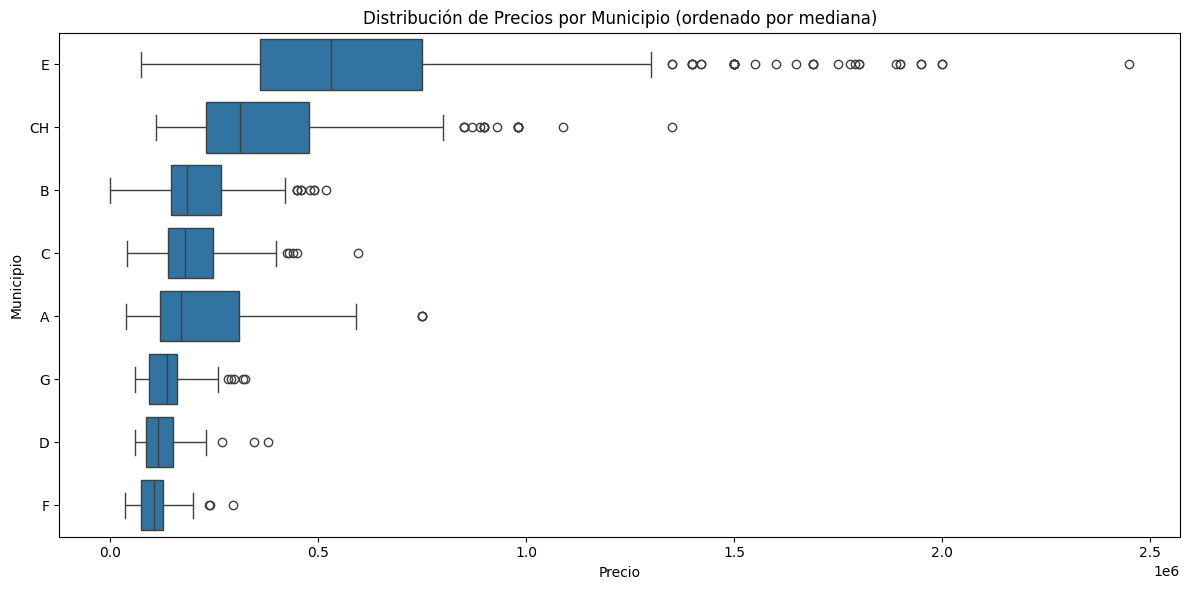

In [9]:
import seaborn as sns

orden_municipios = (df.groupby("municipio")["precio"].median().sort_values(ascending=False).index)

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="precio",
    y="municipio",
    data=df,
    order=orden_municipios
)

plt.title("Distribución de Precios por Municipio (ordenado por mediana)")
plt.xlabel("Precio")
plt.ylabel("Municipio")

plt.tight_layout()
plt.show()

## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [10]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    val_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # Primera división: train+val vs test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Segunda división: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size,
        random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Combinación final
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO con training
    preprocess.fit(X_train)

    # Aplicar transformaciones
    X_train_prep = preprocess.transform(X_train)
    X_val_prep = preprocess.transform(X_val)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_val_prep, X_test_prep,
        y_train, y_val, y_test,
        preprocess,
        X_test.index
    )

In [12]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [13]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):
    # Parámetros por defecto optimizados para MAE
    if params is None:
        params = {
            "objective": "l1",          # minimiza MAE
            "metric": "mae",           # evalúa usando MAE
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model


In [14]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.01,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
  )

    model.fit(X_train, y_train)
    return model


In [15]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,          # más árboles mejora MAE
        max_depth=20,              # evita overfitting, mantiene estabilidad
        min_samples_split=5,       # suaviza los árboles
        min_samples_leaf=2,        # controla extremos, mejora MAE
        max_features="sqrt",       # buen balance bias-variance
        bootstrap=True,            # robusto
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf


from sklearn.model_selection import GridSearchCV

def random_forest_grid_search(X_train, y_train, cv: int = 5, n_jobs: int = -1, verbose: int = 2):

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [200, 400, 600],        # número de árboles
        'max_depth': [None, 10, 20],            # profundidad máxima
        'min_samples_split': [2, 10, 20],       # min de muestras para dividir nodo
        'min_samples_leaf': [1, 5, 10],         # min de muestras por hoja
        'max_features': ['sqrt', 'log2', 0.8]   # nº de features consideradas por split
    }

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        scoring='neg_mean_absolute_error',
        verbose=verbose
    )

    grid_search.fit(X_train, y_train)

    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (CV MAE log):", grid_search.best_score_)

    return grid_search.best_estimator_

In [16]:
def lr_grid_search(X_train, y_train):

    # Definir el modelo base
    lr = LinearRegression()

    # Grilla de hiperparámetros
    param_grid = {
        'fit_intercept': [True, False],
        # 'normalize': [True, False]  # solo si usás sklearn < 1.0
    }

    # Configurar GridSearch
    grid_search = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Entrenar
    grid_search.fit(X_train, y_train)

    # Retornar el mejor modelo
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (CV):", grid_search.best_score_)

    return grid_search.best_estimator_


In [17]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [18]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [19]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [20]:
def evaluation_table(model, X_test_prep, y_test, df_original, test_indices, extra_cols=None):
    # Asegurar array denso para XGBoost
    if sparse.issparse(X_test_prep):
        X_test_prep = X_test_prep.toarray()

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir al valor real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # DataFrame base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
        "Error Absoluto": np.abs(y_test_real - y_pred_real),
        "Error %": 100 * np.abs((y_test_real - y_pred_real) / y_test_real)
    })

    # Agregar columnas originales (ej: url)
    if extra_cols:
        df_extra = df_original.loc[test_indices, extra_cols].reset_index(drop=True)
        results = pd.concat([results.reset_index(drop=True), df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [21]:
features_simple = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage", "Parrillero", "Calefacción", "Año de Construcción", "Jardín", "Piscina", "Patio"]



target = "precio"

## Train Test Splits

In [22]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_val_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_val_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=df,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


In [23]:
data_ch = df[df["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_val_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_val_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


In [24]:
data_e = df[df["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_val_prep_e,
    X_test_prep_e,
    y_train_e,
    y_val_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


## Modelos

Entrenaremos modelos con features simples y features completas en todos los casos.

* Linear regression all_municipios
* RF municipio_ch
* RF municipio_e
* RF all_municipios
* RF Gridsearch municipio_ch
* RF Gridsearch municipio_e
* RF Gridsearch all_municipios

Nombres de modelos simples y completos:

* `model_lr_simple`, `model_lr`
* `rf_municipio_ch_simple`, `rf_municipio_ch`
* `rf_municipio_e_simple`, `rf_municipio_e`
* `rf_all_municipios_simple`, `rf_all_municipios`
* `rf_gridsearch_municipio_ch_simple`, `rf_gridsearch_municipio_ch`
* `rf_gridsearch_municipio_e_simple`, `rf_gridsearch_municipio_e`
* `rf_gridsearch_all_municipios_simple`, `rf_gridsearch_all_municipios`

## `xgb_simple`

In [25]:
xgb_simple = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("XGBoost simple entrenado:", xgb_simple)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [26]:
mse_xgb_simple, r2_xgb_simple, mae_xgb_simple, medae_xgb_simple, mape_xgb_simple, mdape_xgb_simple = evaluate_model(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb_simple}")
print(f"R² Score: {r2_xgb_simple}")
print(f"Mean Absolute Error (MAE): {mae_xgb_simple}")
print(f"Median Absolute Error (XGB): {medae_xgb_simple}")
print(f"MAPE (XGB): {mape_xgb_simple}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_simple}")


Mean Squared Error (MSE): 25685521655.83672
R² Score: 0.7626164170063282
Mean Absolute Error (MAE): 91771.91924966127
Median Absolute Error (XGB): 46603.68750000012
MAPE (XGB): 22.64088945605815
Median Absolute Percentage Error (XGB): 17.452538377192983


## `xgb_ch`

In [27]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost simple entrenado:", xgb_ch)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [28]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 5445066933.029804
R² Score: 0.8391039682600177
Mean Absolute Error (MAE): 49453.17937077704
Median Absolute Error (XGB): 33325.351562500044
MAPE (XGB): 16.255815670744045
Median Absolute Percentage Error (XGB): 12.588602986453193


## `xgb_e`

In [29]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost simple entrenado:", xgb_e)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [30]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 52510499804.48891
R² Score: 0.658153456245211
Mean Absolute Error (MAE): 136914.89305555556
Median Absolute Error (XGB): 69430.59375000023
MAPE (XGB): 20.225734644374686
Median Absolute Percentage Error (XGB): 16.001447368421044


## `model_lgbm_simple` (all municipios)

In [31]:
model_lgbm_simple = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm_simple)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 1179, number of used features: 32
[LightGBM] [Info] Start training from score 12.542545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [32]:
mse_lgbm_simple, r2_lgbm_simple, mae_lgbm_simple, medae_lgbm_simple, mape_lgbm_simple, mdape_lgbm_simple = evaluate_model(
    model_lgbm_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm_simple}")
print(f"R² Score (LGBM): {r2_lgbm_simple}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm_simple}")
print(f"Median Absolute Error (LGBM): {medae_lgbm_simple}")
print(f"MAPE (LGBM): {mape_lgbm_simple}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm_simple}")

Mean Squared Error (LGBM): 27401526036.904396
R² Score (LGBM): 0.7467572386774304
Mean Absolute Error (LGBM): 92846.28872068254
Median Absolute Error (LGBM): 47597.77454173518
MAPE (LGBM): 23.968740177513975
Median Absolute Percentage Error (LGBM): 18.306836362205832


## `lgbm_ch_simple`

In [33]:
# Modelo CH simple
lgbm_ch_simple = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH simple entrenado:", lgbm_ch_simple)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 12
[LightGBM] [Info] Start training from score 12.676076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:
mse_lgbm_ch_simple, r2_lgbm_ch_simple, mae_lgbm_ch_simple, medae_lgbm_ch_simple, mape_lgbm_ch_simple, mdape_lgbm_ch_simple = evaluate_model(
    lgbm_ch_simple,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH simple): {mse_lgbm_ch_simple}")
print(f"R² Score (LGBM CH simple): {r2_lgbm_ch_simple}")
print(f"Mean Absolute Error (LGBM CH simple): {mae_lgbm_ch_simple}")
print(f"Median Absolute Error (LGBM CH simple): {medae_lgbm_ch_simple}")
print(f"MAPE (LGBM CH simple): {mape_lgbm_ch_simple}")
print(f"Median Absolute Percentage Error (LGBM CH simple): {mdape_lgbm_ch_simple}")

Mean Squared Error (LGBM CH simple): 10758474685.75155
R² Score (LGBM CH simple): 0.682098327568345
Mean Absolute Error (LGBM CH simple): 62320.33118401685
Median Absolute Error (LGBM CH simple): 38250.99000432315
MAPE (LGBM CH simple): 17.816799951058844
Median Absolute Percentage Error (LGBM CH simple): 14.398572740114727


## `lgbm_e_simple`

In [35]:
# Modelo E simple
lgbm_e_simple = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E simple entrenado:", lgbm_e_simple)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 431, number of used features: 12
[LightGBM] [Info] Start training from score 13.180633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [36]:
mse_lgbm_e_simple, r2_lgbm_e_simple, mae_lgbm_e_simple, medae_lgbm_e_simple, mape_lgbm_e_simple, mdape_lgbm_e_simple = evaluate_model(
    lgbm_e_simple,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E simple): {mse_lgbm_e_simple}")
print(f"R² Score (LGBM E simple): {r2_lgbm_e_simple}")
print(f"Mean Absolute Error (LGBM E simple): {mae_lgbm_e_simple}")
print(f"Median Absolute Error (LGBM E simple): {medae_lgbm_e_simple}")
print(f"MAPE (LGBM E simple): {mape_lgbm_e_simple}")
print(f"Median Absolute Percentage Error (LGBM E simple): {mdape_lgbm_e_simple}")


Mean Squared Error (LGBM E simple): 71854654481.4693
R² Score (LGBM E simple): 0.5322218341352556
Mean Absolute Error (LGBM E simple): 162293.17607103134
Median Absolute Error (LGBM E simple): 93846.49341881927
MAPE (LGBM E simple): 24.99335059896724
Median Absolute Percentage Error (LGBM E simple): 17.493741852566263


## `model_lr_simple`

Todos los municipios, features simples

In [37]:
model_lr_simple = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr_simple)

Modelo entrenado: LinearRegression()


In [38]:
mse_lr_simple, r2_lr_simple, mae_lr_simple, medae_lr_simple, mape_lr_simple, mdape_lr_simple  = evaluate_model(model_lr_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr_simple}")
print(f"R² Score (Real): {r2_lr_simple}")
print(f"Mean Absolute Error (Real): {mae_lr_simple}")
print(f"Median Absolute Error (Real): {medae_lr_simple}")
print(f"MAPE: {mape_lr_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple}")

Mean Squared Error (Real): 27500317569.358612
R² Score (Real): 0.7458442150582238
Mean Absolute Error (Real): 98418.68993606513
Median Absolute Error (Real): 52259.584671676916
MAPE: 24.980566111984974
Median Absolute Percentage Error (%): 20.807237175199436


## `model_lr_ch`

In [39]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [40]:
mse_lr_simple_ch, r2_lr_simple_ch, mae_lr_simple_ch, medae_lr_simple_ch, mape_lr_simple_ch, mdape_lr_simple_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_simple_ch}")
print(f"R² Score (Real): {r2_lr_simple_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_ch}")
print(f"Median Absolute Error (Real): {medae_lr_simple_ch}")
print(f"MAPE: {mape_lr_simple_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_ch}")

Mean Squared Error (Real): 11892273322.711473
R² Score (Real): 0.648595763922622
Mean Absolute Error (Real): 68210.81226671432
Median Absolute Error (Real): 36505.84398204315
MAPE: 19.39449270778077
Median Absolute Percentage Error (%): 15.40309624753426


## `model_lr_e`

In [41]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [42]:
mse_lr_simple_e, r2_lr_simple_e, mae_lr_simple_e, medae_lr_simple_e, mape_lr_simple_e, mdape_lr_simple_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_simple_e}")
print(f"R² Score (Real): {r2_lr_simple_e}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_e}")
print(f"Median Absolute Error (Real): {medae_lr_simple_e}")
print(f"MAPE: {mape_lr_simple_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_e}")

Mean Squared Error (Real): 57103828753.35197
R² Score (Real): 0.6282506057420927
Mean Absolute Error (Real): 154629.78217066207
Median Absolute Error (Real): 99117.14844391163
MAPE: 24.050292306881875
Median Absolute Percentage Error (%): 19.193467932735008


## `rf_all_municipios_simple`

In [43]:
rf_all_municipios_simple = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [44]:
mse_rf_all_municipios_simple, r2_rf_all_municipios_simple, mae_rf_all_municipios_simple, medae_rf_all_municipios_simple, mape_rf_all_municipios_simple, mdape_rf_all_municipios_simple = evaluate_model(rf_all_municipios_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios_simple}")
print(f"MAPE: {mape_rf_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios_simple}")

Mean Squared Error (Real): 29866112258.187893
R² Score (Real): 0.7239797255070033
Mean Absolute Error (Real): 97667.7682865523
Median Absolute Error (Real): 47258.88831380903
MAPE: 25.530531324624718
Median Absolute Percentage Error (%): 18.973068844757094


## `rf_municipio_ch_simple`

In [45]:
rf_municipio_ch_simple = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [46]:
mse_rf_municipio_ch_simple, r2_rf_municipio_ch_simple, mae_rf_municipio_ch_simple, medae_rf_municipio_ch_simple, mape_rf_municipio_ch_simple, mdape_rf_municipio_ch_simple = evaluate_model(rf_municipio_ch_simple, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch_simple}")
print(f"MAPE: {mape_rf_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch_simple}")

Mean Squared Error (Real): 8852303597.341612
R² Score (Real): 0.7384236891689941
Mean Absolute Error (Real): 64107.72864575348
Median Absolute Error (Real): 47021.627771479194
MAPE: 19.184527302084945
Median Absolute Percentage Error (%): 17.26989095211473


## `rf_municipio_e_simple`

municipio e y features simples

In [47]:
rf_municipio_e_simple = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [48]:
mse_rf_municipio_e_simple, r2_rf_municipio_e_simple, mae_rf_municipio_e_simple, medae_rf_municipio_e_simple, mape_rf_municipio_e_simple, mdape_rf_municipio_e_simple = evaluate_model(rf_municipio_e_simple, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e_simple}")
print(f"MAPE: {mape_rf_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e_simple}")

Mean Squared Error (Real): 52819513477.97539
R² Score (Real): 0.6561417584581468
Mean Absolute Error (Real): 144524.79422653868
Median Absolute Error (Real): 93833.82986869081
MAPE: 21.96639653873555
Median Absolute Percentage Error (%): 17.31148950515299


## `rf_gridsearch_municipio_ch_simple`

In [ ]:
rf_gridsearch_municipio_ch_simple = random_forest_grid_search(X_train_ch_simple, y_train_ch_simple)

print("Modelo entrenado:", rf_gridsearch_municipio_ch_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_municipio_ch_simple, r2_rf_gridsearch_municipio_ch_simple, mae_rf_gridsearch_municipio_ch_simple, medae_rf_gridsearch_municipio_ch_simple, mape_rf_gridsearch_municipio_ch_simple, mdape_rf_gridsearch_municipio_ch_simple = evaluate_model(rf_gridsearch_municipio_ch_simple, X_test_ch_simple, y_test_ch_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_municipio_ch_simple}")
print(f"MAPE: {mape_rf_gridsearch_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_municipio_ch_simple}")

Mean Squared Error (Real): 60366428544.98385
R² Score (Real): 0.5079417315032115
Mean Absolute Error (Real): 135315.74465744683
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042931
Median Absolute Percentage Error (%): 25.704418607020397


## `rf_gridsearch_municipio_e_simple`

In [ ]:
rf_gridsearch_municipio_e_simple = random_forest_grid_search(X_train_e_simple, y_train_e_simple)

print("Modelo entrenado:", rf_gridsearch_municipio_e_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431003
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_municipio_e_simple, r2_rf_gridsearch_municipio_e_simple, mae_rf_gridsearch_municipio_e_simple, medae_rf_gridsearch_municipio_e_simple, mape_rf_gridsearch_municipio_e_simple, mdape_rf_gridsearch_municipio_e_simple = evaluate_model(rf_gridsearch_municipio_e_simple, X_test_e_simple, y_test_e_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_municipio_e_simple}")
print(f"MAPE: {mape_rf_gridsearch_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_municipio_e_simple}")

Mean Squared Error (Real): 60366428544.98386
R² Score (Real): 0.5079417315032115
Mean Absolute Error (Real): 135315.7446574469
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042934
Median Absolute Percentage Error (%): 25.704418607020397


## `rf_gridsearch_all_municipios_simple`

In [ ]:
rf_gridsearch_all_municipios_simple = random_forest_grid_search(X_train_all_municipios_simple, y_train_all_municipios_simple)

print("Modelo entrenado:", rf_gridsearch_all_municipios_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_all_municipios_simple, r2_rf_gridsearch_all_municipios_simple, mae_rf_gridsearch_all_municipios_simple, medae_rf_gridsearch_all_municipios_simple, mape_rf_gridsearch_all_municipios_simple, mdape_rf_gridsearch_all_municipios_simple = evaluate_model(rf_gridsearch_all_municipios_simple, X_test_all_municipios_simple, y_test_all_municipios_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_all_municipios_simple}")
print(f"MAPE: {mape_rf_gridsearch_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_all_municipios_simple}")

Mean Squared Error (Real): 60366428544.98391
R² Score (Real): 0.5079417315032111
Mean Absolute Error (Real): 135315.7446574469
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042933
Median Absolute Percentage Error (%): 25.704418607020397


## Model Performance (solo all municipios)

In [49]:
# Lista de modelos simples
all_models_simple_custom = [
    xgb_simple,
    xgb_ch,
    xgb_e,
    model_lgbm_simple,
    lgbm_ch_simple,
    lgbm_e_simple,
    model_lr_simple,
    model_lr_ch,
    model_lr_e,
    rf_all_municipios_simple,
    rf_municipio_ch_simple,
    rf_municipio_e_simple
]

# Métricas correspondientes (en el mismo orden)
mse_models_simple_custom = [
    mse_xgb_simple,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm_simple,
    mse_lgbm_ch_simple,
    mse_lgbm_e_simple,
    mse_lr_simple,
    mse_lr_simple_ch,
    mse_lr_simple_e,
    mse_rf_all_municipios_simple,
    mse_rf_municipio_ch_simple,
    mse_rf_municipio_e_simple
]

r2_models_simple_custom = [
    r2_xgb_simple,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm_simple,
    r2_lgbm_ch_simple,
    r2_lgbm_e_simple,
    r2_lr_simple,
    r2_lr_simple_ch,
    r2_lr_simple_e,
    r2_rf_all_municipios_simple,
    r2_rf_municipio_ch_simple,
    r2_rf_municipio_e_simple
]

mae_models_simple_custom = [
    mae_xgb_simple,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm_simple,
    mae_lgbm_ch_simple,
    mae_lgbm_e_simple,
    mae_lr_simple,
    mae_lr_simple_ch,
    mae_lr_simple_e,
    mae_rf_all_municipios_simple,
    mae_rf_municipio_ch_simple,
    mae_rf_municipio_e_simple
]

medae_models_simple_custom = [
    medae_xgb_simple,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm_simple,
    medae_lgbm_ch_simple,
    medae_lgbm_e_simple,
    medae_lr_simple,
    medae_lr_simple_ch,
    medae_lr_simple_e,
    medae_rf_all_municipios_simple,
    medae_rf_municipio_ch_simple,
    medae_rf_municipio_e_simple
]

mape_models_simple_custom = [
    mape_xgb_simple,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm_simple,
    mape_lgbm_ch_simple,
    mape_lgbm_e_simple,
    mape_lr_simple,
    mape_lr_simple_ch,
    mape_lr_simple_e,
    mape_rf_all_municipios_simple,
    mape_rf_municipio_ch_simple,
    mape_rf_municipio_e_simple
]

mdape_models_simple_custom = [
    mdape_xgb_simple,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm_simple,
    mdape_lgbm_ch_simple,
    mdape_lgbm_e_simple,
    mdape_lr_simple,
    mdape_lr_simple_ch,
    mdape_lr_simple_e,
    mdape_rf_all_municipios_simple,
    mdape_rf_municipio_ch_simple,
    mdape_rf_municipio_e_simple
]

In [50]:
# Nombres de los modelos
model_names_simple_custom = [
    "XGB simple",
    "XGB CH",
    "XGB E",
    "LGBM simple",
    "LGBM CH simple",
    "LGBM E simple",
    "LR simple",
    "LR CH",
    "LR E",
    "RF all municipios simple",
    "RF CH simple",
    "RF E simple"
]

# Generar la tabla
tabla_simple_custom = crear_tabla_resultados(
    model_names_simple_custom,
    mse_models_simple_custom,
    r2_models_simple_custom,
    mae_models_simple_custom,
    medae_models_simple_custom,
    mape_models_simple_custom,
    mdape_models_simple_custom
)

print("Resultados modelos:")
tabla_simple_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,XGB simple,"91,771.92","46,603.69","25,685,521,655.84",0.76,22.64,17.45
1,XGB CH,"49,453.18","33,325.35","5,445,066,933.03",0.84,16.26,12.59
2,XGB E,"136,914.89","69,430.59","52,510,499,804.49",0.66,20.23,16.00
3,LGBM simple,"92,846.29","47,597.77","27,401,526,036.90",0.75,23.97,18.31
4,LGBM CH simple,"62,320.33","38,250.99","10,758,474,685.75",0.68,17.82,14.40
5,LGBM E simple,"162,293.18","93,846.49","71,854,654,481.47",0.53,24.99,17.49
6,LR simple,"98,418.69","52,259.58","27,500,317,569.36",0.75,24.98,20.81
7,LR CH,"68,210.81","36,505.84","11,892,273,322.71",0.65,19.39,15.40
8,LR E,"154,629.78","99,117.15","57,103,828,753.35",0.63,24.05,19.19
9,RF all municipios simple,"97,667.77","47,258.89","29,866,112,258.19",0.72,25.53,18.97


## Model Performance `xgb_ch`

In [51]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch_simple,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %
0,"300,000.00","560,809.18","260,809.18",86.94
1,"800,000.00","227,543.61","572,456.39",71.56
2,"220,000.00","320,601.67","100,601.67",45.73
3,"530,000.00","291,969.04","238,030.96",44.91
4,"330,000.00","464,787.70","134,787.70",40.84
5,"439,000.00","617,573.85","178,573.85",40.68
6,"110,000.00","152,106.37","42,106.37",38.28
7,"190,000.00","257,596.48","67,596.48",35.58
8,"140,000.00","187,432.26","47,432.26",33.88
9,"735,000.00","493,159.76","241,840.24",32.90


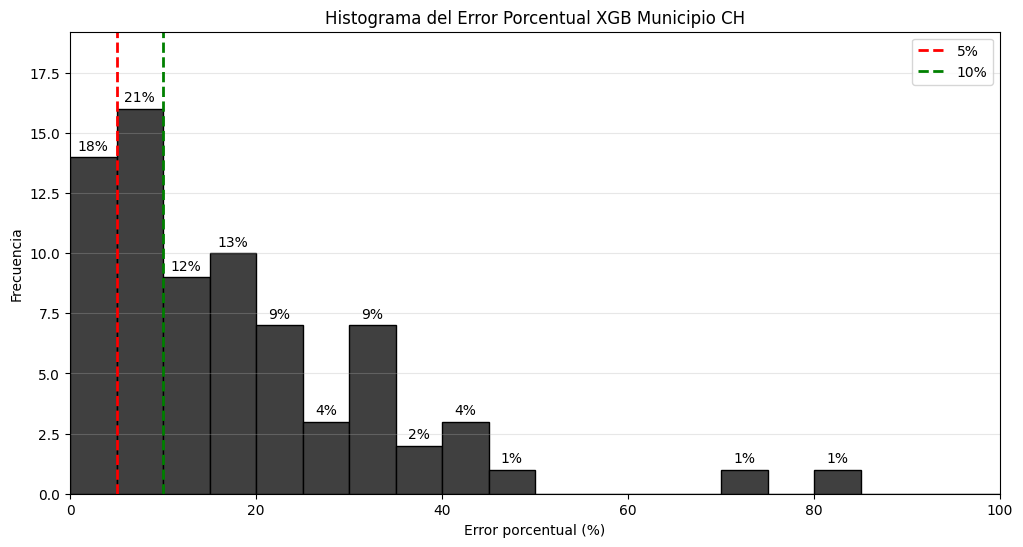

In [52]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

## Model Performance `xgb_simple`

In [53]:
import numpy as np
import pandas as pd

# -----------------------------------------------------------
# Función para predecir precio usando el modelo xgb_simple
# -----------------------------------------------------------

def predict_price_log_model(input_params, preprocess, num_cols, cat_cols, model):
    # Crear DataFrame con los valores del usuario
    df_input = pd.DataFrame([input_params])

    # Aplicar preprocesamiento (OneHot + scaler)
    X_processed = preprocess.transform(df_input[num_cols + cat_cols])

    # Convertir sparse matrix a dense si es necesario
    if hasattr(X_processed, "toarray"):
        X_processed = X_processed.toarray()

    # Predicción del modelo (EN LOG)
    y_pred_log = model.predict(X_processed)[0]

    # Siempre aplicar exponencial porque el modelo predice log(precio)
    y_pred_real = np.exp(y_pred_log)

    return y_pred_real


# -----------------------------------------------------------
# Ejemplo de uso del modelo xgb_simple
# -----------------------------------------------------------

sample_input = {
    "Baños": 4,
    "Dormitorio": 3,
    "Superficie": 300,
    "Superficie Construida": 180,
    "Superficie Terreno": 250,
    "Garage": 2,
    "Parrillero": 1,
    "Calefacción": 1,
    "Año de Construcción": 2022,
    "Jardín": 1,
    "Piscina": 1,
    "Patio": 1,
    "barrio": "Carrasco",
    "municipio": "E"
}

# Llamada a la predicción
prediccion = predict_price_log_model(
    input_params=sample_input,
    preprocess=preprocess_all_municipios,   # tu ColumnTransformer entrenado
    num_cols=features_simple,               # tus columnas numéricas
    cat_cols=cat_cols,                      # tus columnas categóricas
    model=xgb_simple                        # el modelo para usar
)

print("Predicción XGB simple (precio real):", prediccion)


Predicción XGB simple (precio real): 67901.05


In [59]:
import numpy as np
import pandas as pd

# -----------------------------------------------------------
# Función para predecir precio usando el modelo xgb_simple
# -----------------------------------------------------------

def predict_price_log_model(input_params, preprocess, num_cols, cat_cols, model):
    # Crear DataFrame con los valores del usuario
    df_input = pd.DataFrame([input_params])

    # Aplicar preprocesamiento (OneHot + scaler)
    X_processed = preprocess.transform(df_input[num_cols + cat_cols])

    # Convertir sparse matrix a dense si es necesario
    if hasattr(X_processed, "toarray"):
        X_processed = X_processed.toarray()

    # Predicción del modelo (EN LOG)
    y_pred_log = model.predict(X_processed)[0]

    # Siempre aplicar exponencial porque el modelo predice log(precio)
    y_pred_real = np.exp(y_pred_log)

    return y_pred_real


# -----------------------------------------------------------
# Ejemplo de uso del modelo xgb_simple
# -----------------------------------------------------------

sample_input = {
    "Baños": 4,
    "Dormitorio": 3,
    "Superficie": 250,
    "Superficie Construida": 180,
    "Superficie Terreno": 250,
    "Garage": 2,
    "Parrillero": 1,
    "Calefacción": 1,
    "Año de Construcción": 2022,
    "Jardín": 1,
    "Piscina": 1,
    "Patio": 1,
    "barrio": "Carrasco",
    "municipio": "E"
}

# Llamada a la predicción
prediccion = predict_price_log_model(
    input_params=sample_input,
    preprocess=preprocess_all_municipios,
    num_cols=features_simple,
    cat_cols=cat_cols,
    model=model_lr_simple
)

print("Predicción XGB simple (precio real):", prediccion)


Predicción XGB simple (precio real): 463109.3196699754


In [58]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_all_municipios):
    X_test_all_dense = X_test_prep_all_municipios.toarray()
else:
    X_test_all_dense = X_test_prep_all_municipios

X_test_all_df = pd.DataFrame(X_test_all_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_all_reset = y_test_all_municipios.reset_index(drop=True)

# Filas originales del test
test_rows_all = df.loc[test_indices_all_municipios].reset_index(drop=True)

# Evaluación
results_model_xgb_simple = evaluation_table(
    xgb_simple,          # ← modelo que pediste
    X_test_all_df,
    y_test_all_reset,
    test_rows_all,
    extra_cols
)

results_model_xgb_simple.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %
0,"1,020,000.00","29,133.95","990,866.05",97.14
1,"970,000.00","29,147.37","940,852.63",97.00
2,"950,000.00","28,812.71","921,187.29",96.97
3,"750,000.00","24,100.70","725,899.30",96.79
4,"645,000.00","20,924.68","624,075.32",96.76
5,"1,100,000.00","36,378.11","1,063,621.89",96.69
6,"990,000.00","37,171.45","952,828.55",96.25
7,"720,000.00","28,523.18","691,476.82",96.04
8,"1,500,000.00","60,347.94","1,439,652.06",95.98
9,"1,500,000.00","60,347.94","1,439,652.06",95.98


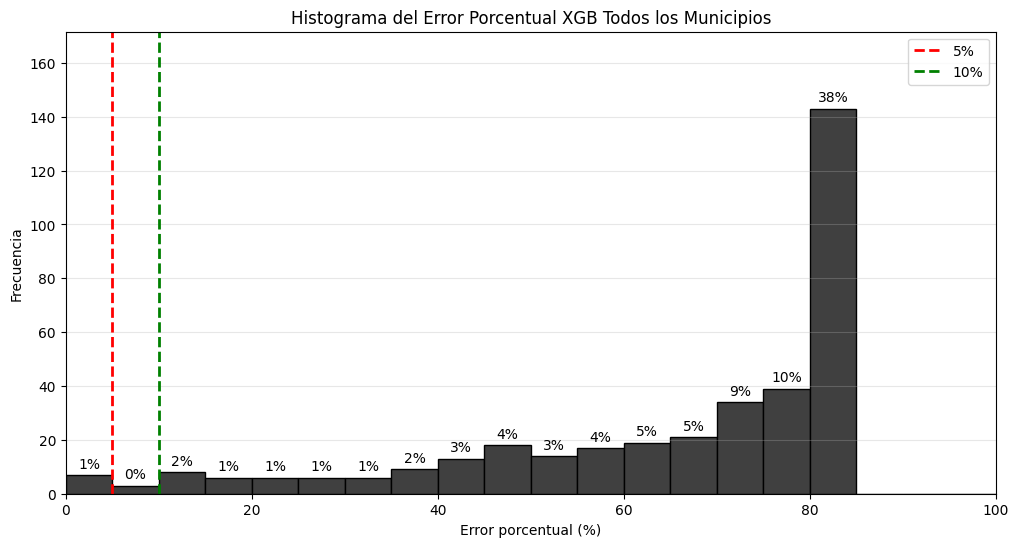

In [57]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_xgb_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

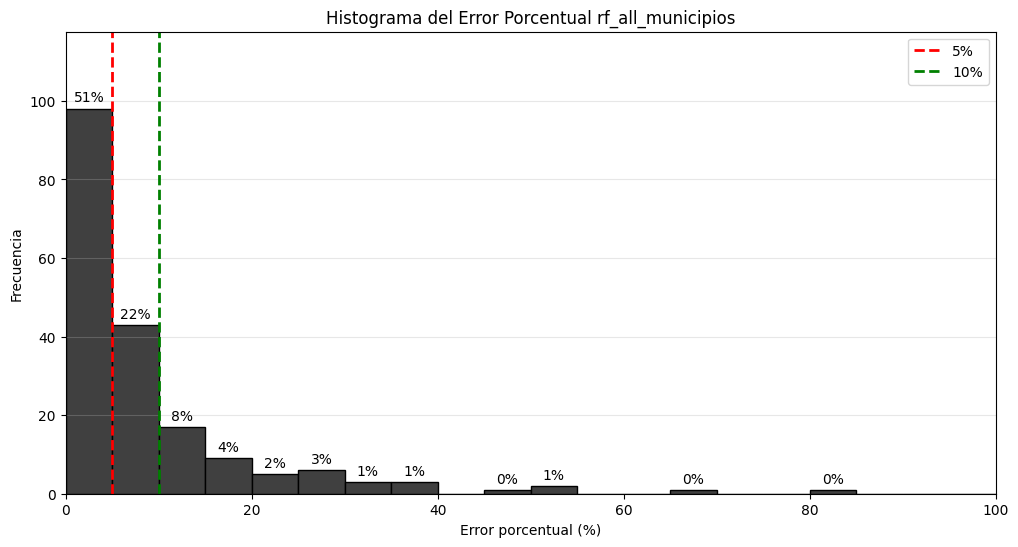

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_rf_all_municipios["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual rf_all_municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

PARA DESPUES

In [ ]:
umbral_10 = 10
umbral_20 = 20
umbral_5 = 5

# Contar
count_below_5 = (results["Error %"] <= umbral_5).sum()
count_below_10 = (results["Error %"] <= umbral_10).sum()
count_above_5 = (results["Error %"] > umbral_5).sum()
count_above_10 = (results["Error %"] > umbral_10).sum()

# Mostrar resultados
print(f"Predicciones con error ≤ {umbral_5}%: {count_below_5}")
print(f"Predicciones con error ≤ {umbral_10}%: {count_below_10}")
print(f"Predicciones con error > {umbral_5}%: {count_above_5}")
print(f"Predicciones con error > {umbral_10}%: {count_above_10}")

# Si querés también el porcentaje respecto al total:
total = len(results)
print("\nPorcentajes:")
print(f"≤ {umbral_5}%: {count_below_5 / total * 100:.2f}%")
print(f"≤ {umbral_10}%: {count_below_10 / total * 100:.2f}%")
print(f"> {umbral_5}%: {count_above_5 / total * 100:.2f}%")
print(f"> {umbral_10}%: {count_above_10 / total * 100:.2f}%")

Predicciones con error ≤ 5%: 98
Predicciones con error ≤ 10%: 141
Predicciones con error > 5%: 91
Predicciones con error > 10%: 48

Porcentajes:
≤ 5%: 51.85%
≤ 10%: 74.60%
> 5%: 48.15%
> 10%: 25.40%


## Exportar modelos con `pickle` y `joblib`

In [ ]:
import pickle
import joblib
import os

# Crear un directorio para guardar los modelos si no existe
output_dir = '/content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models'
os.makedirs(output_dir, exist_ok=True)

# Lista de modelos a exportar y sus nombres
models_to_export = [
    (model_lr_simple, "model_lr_simple"),
    (model_lr, "model_lr"),
    (rf_municipio_ch_simple, "rf_municipio_ch_simple"),
    (rf_municipio_ch, "rf_municipio_ch"),
    (rf_municipio_e_simple, "rf_municipio_e_simple"),
    (rf_municipio_e, "rf_municipio_e"),
    (rf_all_municipios_simple, "rf_all_municipios_simple"),
    (rf_all_municipios, "rf_all_municipios"),
    (rf_gridsearch_municipio_ch_simple, "rf_gridsearch_municipio_ch_simple"),
    (rf_gridsearch_municipio_ch, "rf_gridsearch_municipio_ch"),
    (rf_gridsearch_municipio_e_simple, "rf_gridsearch_municipio_e_simple"),
    (rf_gridsearch_municipio_e, "rf_gridsearch_municipio_e"),
    (rf_gridsearch_all_municipios_simple, "rf_gridsearch_all_municipios_simple"),
    (rf_gridsearch_all_municipios, "rf_gridsearch_all_municipios"),
]

for model, name in models_to_export:
    # Exportar con pickle
    pickle_filename = os.path.join(output_dir, f"{name}.pkl")
    with open(pickle_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Exportado {name} con pickle a: {pickle_filename}")

    # Exportar con joblib
    joblib_filename = os.path.join(output_dir, f"{name}.joblib")
    joblib.dump(model, joblib_filename)
    print(f"Exportado {name} con joblib a: {joblib_filename}")

Exportado model_lr_simple con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr_simple.pkl
Exportado model_lr_simple con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr_simple.joblib
Exportado model_lr con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr.pkl
Exportado model_lr con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr.joblib
Exportado rf_municipio_ch_simple con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch_simple.pkl
Exportado rf_municipio_ch_simple con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch_simple.joblib
Exportado rf_municipio_ch con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch.pkl
Exportado rf_municipio_ch con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipi